In [1]:
import numpy as np
import scipy.constants as phy_const
import matplotlib.pyplot as plt
import pickle
import math as math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
import pandas as pd
import pickle
import glob
import sys
import configparser
import string
from scipy.signal import find_peaks



listAlphabet = list(string.ascii_lowercase)

colors = ['red', 'blue', 'green', 'orange']

In [2]:
#plt.style.use('/home/petronio/style_fp.mplstyle')
plt.rcParams["font.family"] = 'serif'

In [3]:
def find_BM_freq(fft_ampl, fft_freq):
    vec = np.where(fft_freq > 4e3, fft_ampl, 0)
    # print(vec)
    return fft_freq[np.argmax(vec)], np.amax(vec)

def get_files(ResultsData):
    files       = glob.glob(ResultsData + "/*.pkl")
    files.sort(key=os.path.getmtime)
    return files

def calc_curr(Results):
    # try :
    #     time_scale, Id_interp = np.loadtxt(Results + "aacur.dat")
    #     print("Loaded current values")
    # except:
    # open all the files in the directory and sort them to do the video in order
    files       = glob.glob(Results + "/Data/*.pkl")
    filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
    files.sort(key=os.path.getmtime)
    Current = np.zeros(np.shape(files)[0])
    Voltage = np.zeros(np.shape(files)[0])
    time    = np.zeros(np.shape(files)[0])
    # print(np.size(Current))
    Iroll = 0
    # print(f"{np.shape(files)} files found")
    
    for i_save, file in enumerate(files):

        with open(file, 'rb') as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)

        # Save the current
        Current[i_save] = J
        Voltage[i_save] = V
        time[i_save]    = t
    
    time_scale = np.linspace(0, time[-1], len(time)*2)
    Id_interp = np.interp(time_scale, time, Current)
    Va_interp = np.interp(time_scale, time, Voltage) 
    del(files)
    np.savetxt(Results + "cur.dat", np.vstack((time_scale, Id_interp)))
    
    return time_scale, Id_interp, Va_interp#, time, Current, Voltage

def read_input_and_set_globals(input_file):
    '''Reads the input file and sets the global variables
    TO BE COPIED AT THE BEGINNING OF THE MAIN FUNCTION, OTHERWISE THE GLOBAL VARIABLES WILL NOT BE SET'''
    global VG, M, m, R1, R2, A0, LENGTH, L0, alpha_B1, alpha_B2, mdot, Te_Cath, Rext, V0, Estar
    global NBPOINTS, SAVERATE, CFL, TIMEFINAL, TIMESCHEME, Delta_x, alpha_B

    config = configparser.ConfigParser()
    config.read(input_file)

    physicalParameters = config['Physical Parameters']

    VG       = float(physicalParameters['Gas velocity'])
    M        = float(physicalParameters['Ion Mass'])*phy_const.m_u
    m        = phy_const.m_e
    R1       = float(physicalParameters['Inner radius'])
    R2       = float(physicalParameters['Outer radius'])
    A0       = np.pi * (R2 ** 2 - R1 ** 2)
    LENGTH   = float(physicalParameters['Length of axis'])
    L0       = float(physicalParameters['Length of thruster'])
    alpha_B1 = float(physicalParameters['Anomalous transport alpha_B1'])
    alpha_B2 = float(physicalParameters['Anomalous transport alpha_B2'])
    mdot     = float(physicalParameters['Mass flow'])
    Te_Cath  = float(physicalParameters['Temperature Cathode'])
    Rext     = float(physicalParameters['Ballast resistor'])
    V0       = float(physicalParameters['Voltage'])
    Estar    = float(physicalParameters['Crossover energy'])
    # WALLCOLLS= bool(physicalParameters['Wall collisions'])               # Wall collisions
    Circuit  = bool(config.getboolean('Physical Parameters', 'Circuit', fallback=False)) # RLC Circuit


    NumericsConfig = config['Numerical Parameters']

    NBPOINTS  = int(NumericsConfig['Number of points'])
    SAVERATE  = int(NumericsConfig['Save rate'])
    CFL       = float(NumericsConfig['CFL'])
    TIMEFINAL = float(NumericsConfig['Final time'])
    TIMESCHEME = NumericsConfig['Time integration']
    AlphaModel = NumericsConfig['Anomalous transport model']         

    Delta_x  = LENGTH/NBPOINTS
    x_center = np.linspace(0, LENGTH, NBPOINTS)
    
     
    # Magnetic field configuration
    MagneticFieldConfig = config['Magnetic field configuration']

    if MagneticFieldConfig['Type'] == 'Default':
        # print(MagneticFieldConfig['Type'] + ' Magnetic Field')

        Bmax     = float(MagneticFieldConfig['Max B-field'])                  # Max Mag field
        # LB       = float(MagneticFieldConfig['Length B-field'])               # Length for magnetic field
        # LBMax    = float(MagneticFieldConfig['Position maximum B-Field'])           # length of thruster (position of B_max)
        # saveBField = bool(MagneticFieldConfig['Save B-field'])
def alpha_B():
    if AlphaModel == 'Step' :
        alpha_B = (np.ones(NBPOINTS) * alpha_B1)  # Anomalous transport coefficient inside the thruster
        alpha_B = np.where(x_center < L0, alpha_B, alpha_B2)  # Anomalous transport coefficient in the plume
    elif AlphaModel == 'Linear' :
        alpha_B = []
        for i in range(len(x_center)) :
            alpha_B.append(((alpha_B2-alpha_B1)/LENGTH)*x_center[i]+alpha_B1)
    elif AlphaModel == 'Capelli' :
        pass
    elif AlphaModel == 'Lafleur' :
        pass
    elif AlphaModel == 'Chodura' :
        pass
    elif AlphaModel == 'Data-driven' :
        pass
    alpha_B_smooth = np.copy(alpha_B)

    # smooth between alpha_B1 and alpha_B2
    for index in range(10, NBPOINTS - 9):
        alpha_B_smooth[index] = np.mean(alpha_B[index-10:index+10])
    return(alpha_B)


In [4]:
def make_fig_curr_FFT(figures_path, path, indx, indy, do_fig = False):
    # if os.path.exists(path + "data_curr_BM_freq.txt"):
    # try:
    #     mean_current, mean_voltage, freqz, std_curr, alpha_B1v, alpha_B2v = np.loadtxt(path + "data_curr_BM_freq.txt", skiprows=1)
    #     print("loaded")
    # except:
    if 1>0:
        print(path)
        ResultConfig = path +'/Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
    
        time_scale, Id_interp, Va_interp = calc_curr(path)
        alpha_B1v = float(physicalParameters['Anomalous transport alpha_B1'])
        alpha_B2v = float(physicalParameters['Anomalous transport alpha_B2'])

        mean_current = np.mean(Id_interp[np.where(time_scale*1e3 > 1.5)])
        mean_voltage = np.mean(Va_interp[np.where(time_scale*1e3 > 1.5)])
        std_curr = np.std(Id_interp[np.where(time_scale*1e3 > 1.5)])
        # std_curr = np.amax(Id_interp[np.where(time_scale*1e3 > 1.5)]) - np.amin(Id_interp[np.where(time_scale*1.5e3 > 1.5)])
        print(f"a_ch = {indx:.0f}, a_pl = {indy:.0f}", 
              f"a_ch = {alpha_B1v:.2e}, a_pl = {alpha_B2v:.2e}", 
              f"mean curr = {mean_current:.2f}, ampl =  {std_curr:.2f}",
              # f"max {np.amax(Id_interp[np.where(time_scale*1.5e3 > 1.5)]):.3f}, min {np.amin(Id_interp[np.where(time_scale*1.5e3 > 1.5)]):.3f}",
              # f"amax {1e3*time_scale[np.argmax(Id_interp[np.where(time_scale*1.5e3 > 1.5)])]:.3f}, amin {1e3*time_scale[np.argmin(Id_interp[np.where(time_scale*1.5e3 > 1.5)])]:.3f}"
              )
        curr_fft = np.fft.fft(Id_interp)
        freq = np.fft.fftfreq(Id_interp.shape[-1], d=time_scale[1])
        freq_BM, ampl = find_BM_freq(np.abs(curr_fft), freq)
        vec = np.where(freq > 4e3, np.abs(curr_fft), 0)
        peaks, peaks_heigth = find_peaks(vec, height=0.1, distance=5)

        if do_fig:
            plt.figure(figsize=(10,4))
            gs1 = gridspec.GridSpec(1, 2)
            gs1.update(hspace=0.25, wspace=0.45, left=0.2, right=0.95, bottom=0.15)
            ax0 = plt.subplot(gs1[0])
            ax1 = plt.subplot(gs1[1])
        
            ax0.set_ylabel("$I_{\mathrm{d}}$ [A]", fontsize=13, color="darkred")
            ax1.set_ylabel("FFT [a.u.]", fontsize=13)
            ax0.set_xlabel("Time [ms]", fontsize=13)
            ax1.set_xlabel("Frequency [kHz]", fontsize=13)
            ax0.plot(time_scale*1e3, Id_interp, label="interpolated current", color="darkred")
        
            mean_current = np.mean(Id_interp[np.where(time_scale*1e3 > .2)])
            mean_voltage = np.mean(Va_interp[np.where(time_scale*1e3 > .2)])
            std_curr = np.std(Id_interp[np.where(time_scale*1e3 > .2)])
        
            ax0.set_xlim(0, int((time_scale[-1])*1e3 + .9))
            
            if np.isnan(mean_current):
                ax0.text(0.002, 0.9, f"(a) Mean current -- A", fontsize=13, transform=ax0.transAxes)
            else:
                ax0.text(0.002, 0.9, f"(a) Mean current {mean_current:.2f} A", fontsize=13, transform=ax0.transAxes)
                
            if np.isnan(mean_current):
                try:
                    freqs_BM[ind-1] = np.nan
                except:
                    pass
            ax0.axhline(y=mean_current, linestyle='--', color="darkred")
            ax0.axvline(x=.2, linestyle='--', color="darkgray")
            ax0.set_ylim(0, np.amax(Id_interp[-100:])*1.5)
            ax0.grid(False)
        
            ax_V=ax0.twinx()
            ax_V.plot(time_scale/1e-3, Va_interp, color="darkgreen", zorder=1, alpha=.4)
            ax_V.axhline(y=mean_voltage, linestyle='--', color="darkgreen", zorder=1)
        
            ax_V.set_ylabel(r'Voltage [V]', color="darkgreen")
            ax_V.grid(False)
    
            t1 = ax0.text(0.65, 0.9, rf"$\alpha_c$ : {float(physicalParameters['Anomalous transport alpha_B1']):.5f} ", fontsize=13, transform=ax0.transAxes, zorder=10)
            t2 = ax0.text(0.65, 0.8, rf"$\alpha_p$ : {float(physicalParameters['Anomalous transport alpha_B2']):.5f} ", fontsize=13, transform=ax0.transAxes, zorder=10)
            t1.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
            t2.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
        # MAKE AN FFT
            
            try:
                if peaks[0] == 13:
                    print(ind, peaks_heigth['peak_heights'][0], peaks_heigth['peak_heights'][1])
                    peaks = peaks[1:]
                while np.abs(curr_fft[peaks[0]]) < .5*np.amax(np.abs(curr_fft[peaks[:]])):
                    peaks = peaks[1:]
            except:
                peaks = [0,0,0]
                
            ax1.plot(freq[:int(len(freq)/2-1)]/1e3, np.abs(curr_fft[:int(len(freq)/2-1)])/ampl, marker='o', color="darkblue", linestyle="-")
            ax1.plot(freq[peaks]/1e3, np.abs(curr_fft[peaks])/ampl, marker='x', color="magenta", label="peaks", linestyle='None')
        
            ax1.set_xlim(0, 100)
            ax1.set_ylim(0, 1.2)
            ax1.text(0.002, 0.9, f"(b) BM frequency {freq[peaks[0]]/1e3:.2f} kHz", fontsize=13, transform=ax1.transAxes)
            ax1.grid(False)
            plt.savefig(figures_path + f"current_fft_{indx}_{indy}.png", dpi=300, transparent=True, bbox_inches='tight')
        np.savetxt(path + "data_curr_BM_freq.txt", np.transpose([mean_current, mean_voltage, freq[peaks[0]]/1e3, std_curr, alpha_B1v, alpha_B2v]), header="mean_current [A], mean_voltage [V], freq_BM [kHz], std_current [A], alpha_B1v, alpha_B2v")
#    np.savetxt(path + "data_curr_BM_freqa.txt", (mean_current, mean_voltage, freq[peaks[0]]/1e3, std_curr), header="mean_current [A], mean_voltage [V], freq_BM [kHz], std_current [A]", newline=" ")
    return alpha_B1v, alpha_B2v, mean_current, std_curr

#    plt.savefig(figures_path + f"current_fft_{ind}.png", dpi=300, transparent=True, bbox_inches='tight')
    
#    if mean_curr[ind-2] == 0:
#        mean_curr[ind-2] = np.nan
#        std_curr[ind-2] = np.nan
#    np.savetxt(path + "data_curr_BM_freq.txt", np.transpose([mean_curr[:], mean_vol freqs_BM[:], std_curr[:]]), header="mean_current [A], freq_BM [kHz], std_current [A]")

def calc_current(Results):
    ResultsFigs = Results+"/Figs"
    ResultsData = Results+"/Data"

    if not os.path.exists(ResultsFigs):
        os.makedirs(ResultsFigs)
    

    # open all the files in the directory and sort them to do the video in order
    files       = glob.glob(ResultsData + "/*.pkl")

    filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
    files.sort(key=os.path.getmtime)
    # print(files[:10])
    # print(filesSorted[:10])

    Current = np.zeros(np.shape(files)[0])
    Voltage = np.zeros(np.shape(files)[0])
    time    = np.zeros(np.shape(files)[0])
    ng_tot = []
    ni_tot = []
    vi_tot = []
    Te_tot = []
    ve_tot = []
    try :
        time,Current,Voltage = np.loadtxt(Results + "/acur_volt.dat")
        print("Loaded current and voltage values")
    except:
        for i_save, file in enumerate(files):
            
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
            
            # Save the current
            Current[i_save] = J
            Voltage[i_save] = V
            time[i_save]    = t
    for i_save, file in enumerate(files):
        with open(file, 'rb') as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
            ng_tot.append(P[0,:])
            ni_tot.append(P[1,:])
            vi_tot.append(P[2,:])
            Te_tot.append(P[3,:])
            ve_tot.append(P[4,:])
  
        np.savetxt(Results + "/cur_volt.dat", np.vstack((time,Current,Voltage)))
    print("final time: ", time[-1])
    # print(Current)


## 1D graphs - macro

In [5]:

path = "Results_PPSX00/linear/"



try:
    if int(path[-3:-1]) > 9:
        lungh = 10
except:
    lungh = 8
    
lungh = 5
mean_curr = np.zeros((2*lungh+1, 2*lungh+1))
std_curr = np.zeros((2*lungh+1, 2*lungh+1))
alpha_B1 = np.zeros(2*lungh+1)
alpha_B2 = np.zeros(2*lungh+1)

# Modifier path pour inclure les différents alphaB
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        folder = path + "data_"+str(indx)+"_"+str(indy)
        # try:
        alpha_B1[lungh+indx], alpha_B2[lungh+indy], mean_curr[lungh+indx, lungh+indy], std_curr[lungh+indx, lungh+indy] = make_fig_curr_FFT(path + '/figures', folder, indx, indy, do_fig=True)
        # except:
        #     print(f"error {indx} {indy}")
        #     alpha_B1[indx-1], alpha_B2[indy-1], mean_curr[indx-1, indy-1], std_curr[indx-1, indy-1] = 0.,0.,0.,0.
        plt.close()
alpha_B1_save = alpha_B1
alpha_B2_save = alpha_B2

Results_PPSX00/linear/data_-5_-5
a_ch = -5, a_pl = -5 a_ch = 5.00e-03, a_pl = 5.00e-03 mean curr = 1.04, ampl =  0.00
Results_PPSX00/linear/data_-5_-4
a_ch = -5, a_pl = -4 a_ch = 5.00e-03, a_pl = 6.00e-03 mean curr = 1.15, ampl =  0.01
Results_PPSX00/linear/data_-5_-3
a_ch = -5, a_pl = -3 a_ch = 5.00e-03, a_pl = 7.00e-03 mean curr = 1.27, ampl =  0.02
Results_PPSX00/linear/data_-5_-2
a_ch = -5, a_pl = -2 a_ch = 5.00e-03, a_pl = 8.00e-03 mean curr = 1.38, ampl =  0.04
Results_PPSX00/linear/data_-5_-1
a_ch = -5, a_pl = -1 a_ch = 5.00e-03, a_pl = 9.00e-03 mean curr = 1.51, ampl =  0.10
Results_PPSX00/linear/data_-5_0
a_ch = -5, a_pl = 0 a_ch = 5.00e-03, a_pl = 1.00e-02 mean curr = 1.62, ampl =  0.20
Results_PPSX00/linear/data_-5_1
a_ch = -5, a_pl = 1 a_ch = 5.00e-03, a_pl = 1.10e-02 mean curr = 1.73, ampl =  0.44
Results_PPSX00/linear/data_-5_2
a_ch = -5, a_pl = 2 a_ch = 5.00e-03, a_pl = 1.20e-02 mean curr = 1.83, ampl =  0.72
Results_PPSX00/linear/data_-5_3
a_ch = -5, a_pl = 3 a_ch = 5.0

In [6]:
## CURRENT

(11, 11) (11,) (11,)
0.009 0.008 2.0200795845817643 -0.48869041469140484
0.015 0.015 3.8542582075702954 89.8649363335121


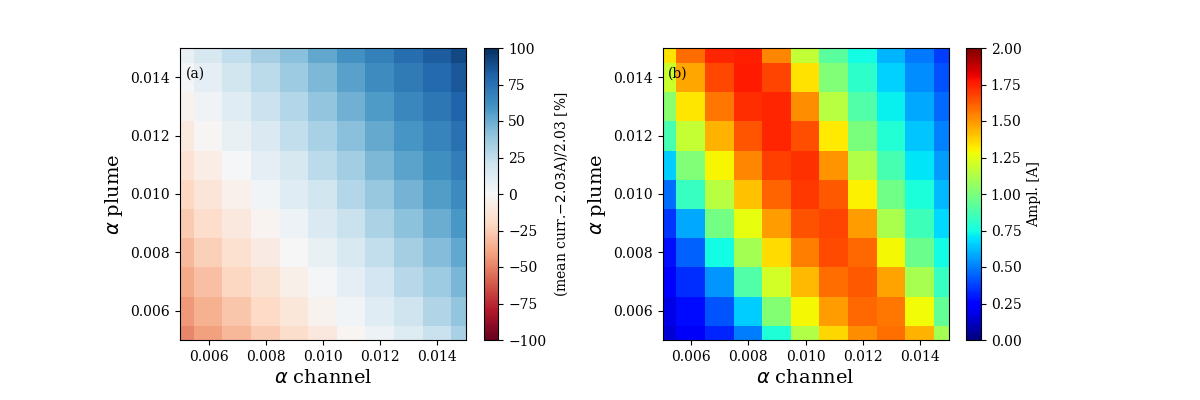

In [7]:
%matplotlib widget
# plt.figure()
# plt.pcolor(alpha_B1[:], alpha_B2[:], mean_curr_scale[:,:], cmap='magma')
xlabel = r"$\alpha$ channel"
ylabel = r"$\alpha$ plume"

mean_curr_scaled = (mean_curr - 2.03)*100/2.03
plt.figure(figsize=(12, 4))  # Set figure size


gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
assi = [ax0, ax1]

vmin=0
if int(np.amin(mean_curr_scaled)+1)>10:
    vmin = int(np.amin(mean_curr_scaled))
vmax=int(np.amax(np.abs(mean_curr_scaled))+1)
vmin = -vmax
vmax = 100
vmin = -vmax

print(np.shape(mean_curr_scaled),np.shape(alpha_B1),np.shape(alpha_B2))
im = ax0.pcolor(alpha_B1, alpha_B2, mean_curr_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = r"(mean curr.$- 2.03$A)/2.03 [%]")
# plt.sup_title(title, fontsize=16)  # Add a title

vmin=0
if int(np.amin(std_curr)+1)>10:
    vmin = int(np.amin(std_curr))
vmax=int(np.amax(std_curr)+1)
# vmax=int(10)
im = ax1.pcolor((alpha_B1), (alpha_B2), std_curr.T, cmap='jet', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = "Ampl. [A]")


for ax in assi:
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_xlabel(xlabel, fontsize=14)  # Add label for x-axis
    ax.set_ylabel(ylabel, fontsize=14)  # Add label for y-axis
    ax.set_xlim(0.005, 0.015)
    ax.set_ylim(0.005, 0.015)
    if path == "test_multiple_alpha_B_SPT100/alpha_CP3/":
        ax.set_xticks(np.arange(.005, 0.035, 0.005))
    
    
      # Add color bar with label
    
    ax.grid(False)  # Turn off grid lines

ax0.text(0.02, 0.9, "(a)", transform=ax0.transAxes)
ax1.text(0.02, 0.9, "(b)", transform=ax1.transAxes)

ind_x_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
mean_curr_opti = 50
ind_x_worst = 0 # We look for the set of alphaB with the highest error
indy_worst = 0
mean_curr_worst = 0

for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        if abs(mean_curr[lungh+indx, lungh+indy]-2.03) < mean_curr_opti :
            indx_opti = indx
            indy_opti = indy
            mean_curr_opti = abs(mean_curr[lungh+indx, lungh+indy]-2.03)
        elif abs(mean_curr[lungh+indx, lungh+indy]-2.03) > mean_curr_worst :
            indx_worst = indx
            indy_worst = indy
            mean_curr_worst = abs(mean_curr[lungh+indx, lungh+indy]-2.03)
print(alpha_B1[lungh+indx_opti], alpha_B2[lungh+indy_opti],mean_curr[lungh+indx_opti, lungh+indy_opti], (mean_curr[lungh+indx_opti, lungh+indy_opti]-2.03)*100/2.03)
print(alpha_B1[lungh+indx_worst], alpha_B2[lungh+indy_worst],mean_curr[lungh+indx_worst, lungh+indy_worst], (mean_curr[lungh+indx_worst, lungh+indy_worst]-2.03)*100/2.03)

# plt.tight_layout()  # Adjust layout to prevent overlap

# print("alpha channel:", alpha_B1)
# print("alpha plume:", alpha_B2)

#plt.savefig(path+"/figures/mean_curr_ampl.png", bbox_inches='tight', transparent=True, dpi = 300) 


In [8]:
## THRUST

(11, 11) (11,) (11,)
0.007 0.014 0.0350832424713695 0.23783563248427497
0.015 0.015 0.051119645940679595 46.056131259084545


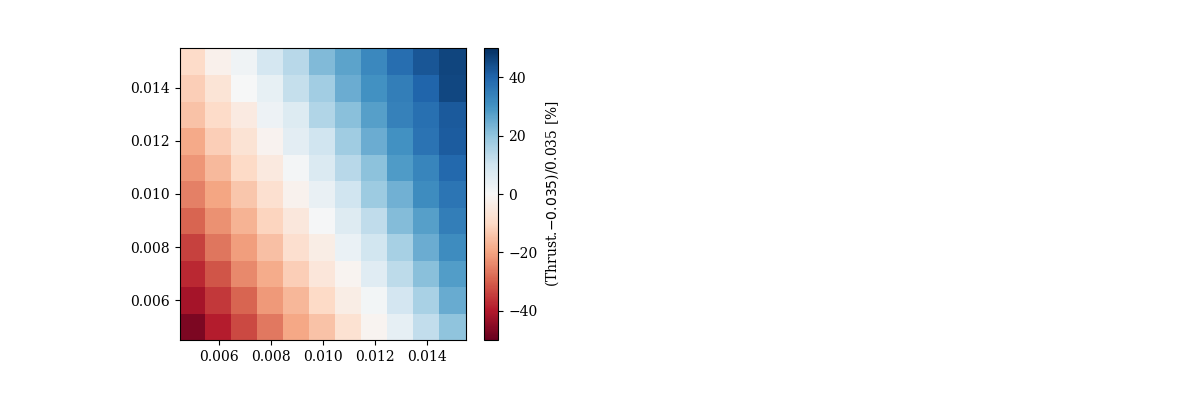

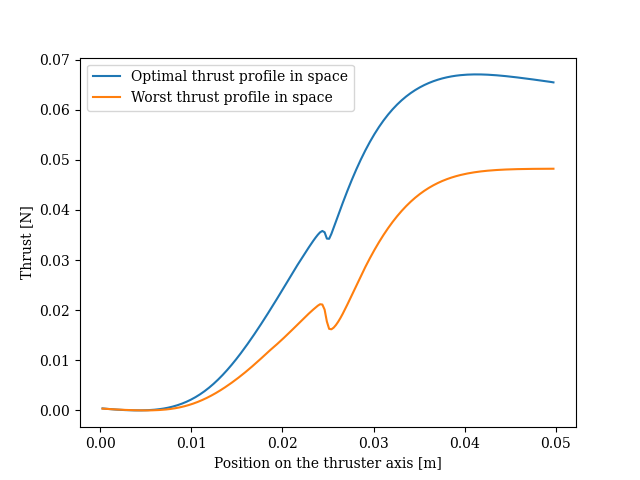

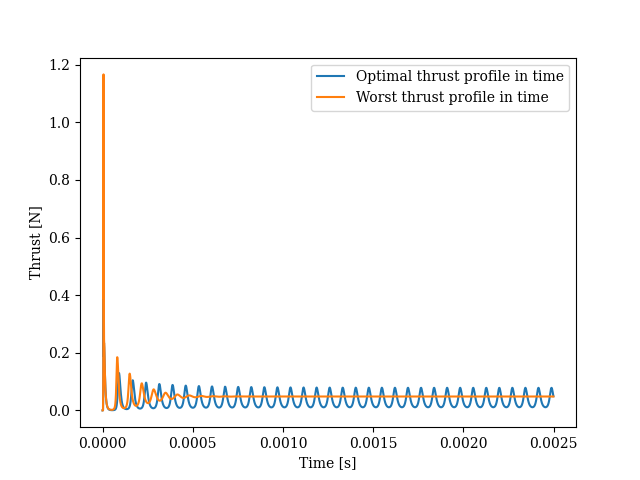

In [9]:

path = "Results_PPSX00/linear"
config = path +'/data_-1_-1/Configuration.cfg'
read_input_and_set_globals(config)


Thrust = np.zeros((2*lungh+1, 2*lungh+1))
alpha_B1 = []
alpha_B2 = []


for indx in range(-lungh,lungh+1):
    alpha_B1.append(indx/1000+0.01)
    for indy in range(-lungh,lungh+1):
        ni_tot = []
        vi_tot = []
        ni_temp = []
        vi_temp = []
        time_save = []
        t_tot = 0
        ni_av = 0
        vi_av = 0
        Results = path + "/data_"+str(indx)+"_"+str(indy)
        ResultsFigs = Results+"/Figs"
        ResultsData = Results+"/Data"
        if not os.path.exists(ResultsFigs):
            os.makedirs(ResultsFigs)
        files       = glob.glob(ResultsData + "/*.pkl")
        for i_save, file in enumerate(files):
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                time_save.append(t)
                ni_tot.append(P[1,:])
                vi_tot.append(P[2,:])
        for i in range (len(vi_tot)):
            ni_temp.append(np.mean(ni_tot[i][-10:-3]))
            vi_temp.append(np.mean(vi_tot[i][-10:-3]))
        time_scale = np.linspace(0, time_save[-1], len(time_save)*2+1)
        ni_av = np.mean(np.interp(time_scale, time_save, ni_temp))
        vi_av = np.mean(np.interp(time_scale, time_save, vi_temp))
        Thrust[indx+lungh][indy+lungh] = M*A0*ni_av*vi_av**2

Thrust_scaled = (Thrust - 0.035)*100/0.035
alpha_B2 = alpha_B1


plt.figure(figsize=(12, 4))  # Set figure size
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
ax0 = plt.subplot(gs1[0])
assi = [ax0, ax1]


vmin=0
if int(np.amin(Thrust_scaled)+1)>10:
    vmin = int(np.amin(Thrust_scaled))
vmax=int(np.amax(np.abs(Thrust_scaled))+1)
vmax = 50
vmin = -vmax

print(np.shape(Thrust_scaled),np.shape(alpha_B1),np.shape(alpha_B2))
im = ax0.pcolor(alpha_B1, alpha_B2, Thrust_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = r"(Thrust.$- 0.035$)/0.035 [%]")


# Extremal cases
indx_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
thrust_opti = 50
indx_worst = 0 # We look for the set of alphaB with the highest error
indx_worst = 0
thrust_worst = 0
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        if abs(Thrust[lungh+indx, lungh+indy]-0.035) < thrust_opti :
            indx_opti = indx
            indy_opti = indy
            thrust_opti = abs(Thrust[lungh+indx, lungh+indy]-0.035)
        elif abs(Thrust[lungh+indx, lungh+indy]-0.035) > thrust_worst :
            indx_worst = indx
            indy_worst = indy
            thrust_worst = abs(Thrust[lungh+indx, lungh+indy]-0.035)
print(alpha_B1[lungh+indx_opti], alpha_B2[lungh+indy_opti],Thrust[lungh+indx_opti, lungh+indy_opti], (Thrust[lungh+indx_opti, lungh+indy_opti]-0.035)*100/0.035)
print(alpha_B1[lungh+indx_worst], alpha_B2[lungh+indy_worst],Thrust[lungh+indx_worst, lungh+indy_worst], (Thrust[lungh+indx_worst, lungh+indy_worst]-0.035)*100/0.035)
plt.show()

# Variations in time

plt.figure()
Thrust_profile_opti = []
ni_tot = []
vi_tot = []
time_save = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot)) :
    Thrust_profile_opti.append(np.mean(M*A0*ni_tot[i][-10:-3]*vi_tot[i][-10:-3]**2))
plt.plot(time_save, Thrust_profile_opti ,label = 'Optimal thrust profile in time')
Thrust_profile_worst = []
ni_tot = []
vi_tot = []
time_save = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot)) :
    Thrust_profile_worst.append(np.mean(M*A0*ni_tot[i][-10:-3]*vi_tot[i][-10:-3]**2))

plt.plot(time_save, Thrust_profile_worst ,label = 'Worst thrust profile in time')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')

# Variations in space
plt.figure()
Thrust_profile_opti = []
ni_tot = []
vi_tot = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    Thrust_profile_opti.append(np.mean(M*A0*ni_tot[-100][i]*vi_tot[-100][i]**2))
plt.plot(x_center, Thrust_profile_opti ,label = 'Optimal thrust profile in space')
Thrust_profile_worst = []
ni_tot = []
vi_tot = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    Thrust_profile_worst.append(np.mean(M*A0*ni_tot[-100][i]*vi_tot[-100][i]**2))

plt.plot(x_center, Thrust_profile_worst ,label = 'Worst thrust profile in space')
plt.legend()
plt.xlabel('Position on the thruster axis [m]')
plt.ylabel('Thrust [N]')
plt.show()


In [10]:
## ISP

9.80665
(11, 11) (11,) (11,)
0.005 0.014 1449.903534214905 -0.0066528127651728376
0.015 0.015 1860.4641533598565 28.307872645507345


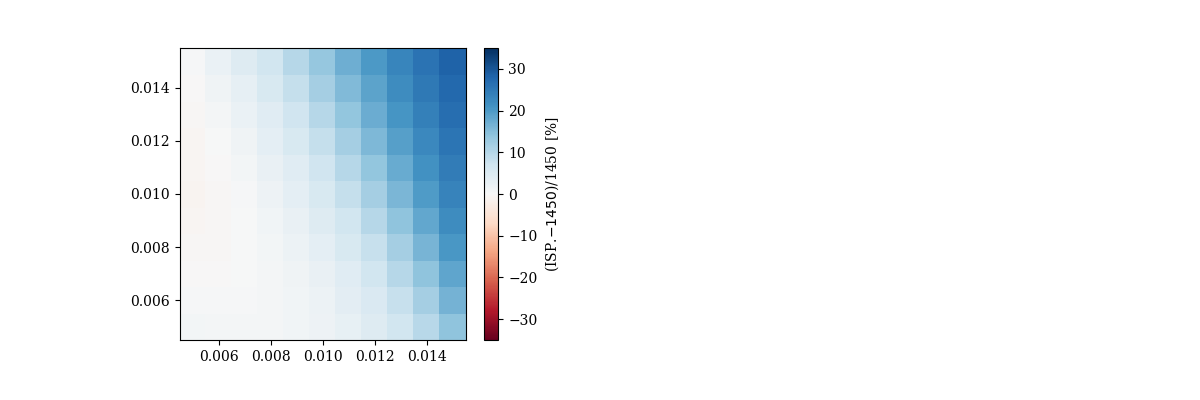

Text(0, 0.5, 'alpha_B [/]')

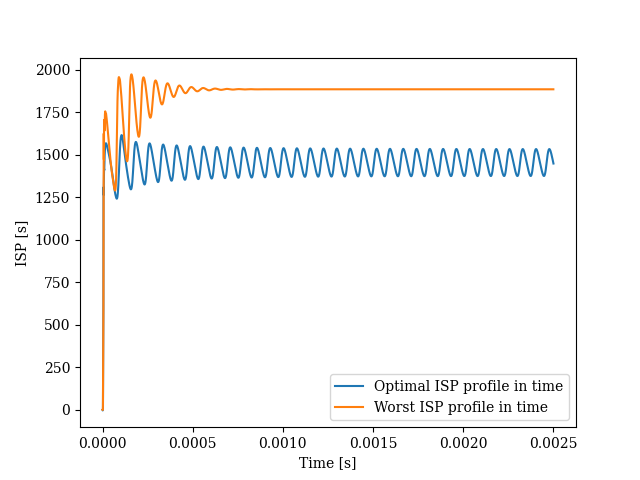

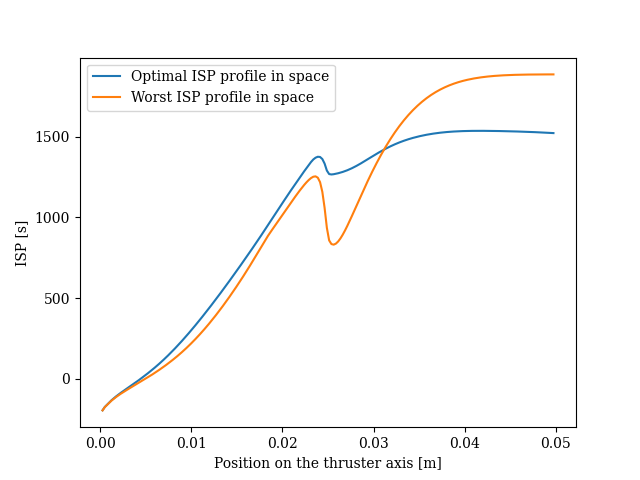

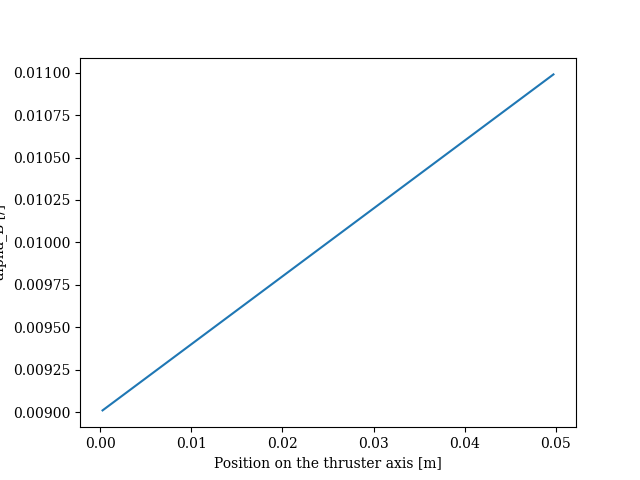

In [23]:
path = "Results_PPSX00/linear"
config = path +'/data_-1_-1/Configuration.cfg'
read_input_and_set_globals(config)

g        = phy_const.g

ISP = np.zeros((2*lungh+1, 2*lungh+1))
alpha_B1 = []
alpha_B2 = []


for indx in range(-lungh,lungh+1):
    alpha_B1.append(indx/1000+0.01)
    for indy in range(-lungh,lungh+1):
        t_tot =0
        time_save = []
        vi_tot = []
        vi_av = 0
        vi_temp = []
        Results = path + "/data_"+str(indx)+"_"+str(indy)
        ResultsFigs = Results+"/Figs"
        ResultsData = Results+"/Data"
        if not os.path.exists(ResultsFigs):
            os.makedirs(ResultsFigs)
        files       = glob.glob(ResultsData + "/*.pkl")
        for i_save, file in enumerate(files):
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                time_save.append(t)
                vi_tot.append(P[2,:])
        for i in range(len(vi_tot)) :
            vi_temp.append(np.mean(vi_tot[i][-10:-3]))
        time_scale = np.linspace(0, time_save[-1], len(time_save)*2+1)
        vi_av = np.mean(np.interp(time_scale, time_save, vi_temp))
        ISP[indx+lungh][indy+lungh] = vi_av/g

ISP_scaled = (ISP - 1450)*100/1450
alpha_B2 = alpha_B1

plt.figure(figsize=(12, 4))  # Set figure size
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
ax0 = plt.subplot(gs1[0])
assi = [ax0, ax1]


vmin=0
if int(np.amin(ISP_scaled)+1)>10:
    vmin = int(np.amin(ISP_scaled))
vmax=int(np.amax(np.abs(ISP_scaled))+1)
vmin = -vmax
vmax = 35
vmin = -vmax
print(phy_const.g)
print(np.shape(ISP_scaled),np.shape(alpha_B1),np.shape(alpha_B2))
im = ax0.pcolor(alpha_B1, alpha_B2, ISP_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = r"(ISP.$- 1450$)/1450 [%]")


# Extremal cases
ind_x_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
isp_opti = 50
indx_worst = 0 # We look for the set of alphaB with the highest error
indy_worst = 0
isp_worst = 50
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        if abs(ISP[lungh+indx, lungh+indy]-1450) < isp_opti :
            indx_opti = indx
            indy_opti = indy
            isp_opti = abs(ISP[lungh+indx, lungh+indy]-1450)
        elif abs(ISP[lungh+indx, lungh+indy]-1450) > isp_worst :
            indx_worst = indx
            indy_worst = indy
            isp_worst = abs(ISP[lungh+indx, lungh+indy]-1450)
print(alpha_B1[lungh+indx_opti], alpha_B2[lungh+indy_opti],ISP[lungh+indx_opti, lungh+indy_opti], (ISP[lungh+indx_opti, lungh+indy_opti]-1450)*100/1450)
print(alpha_B1[lungh+indx_worst], alpha_B2[lungh+indy_worst],ISP[lungh+indx_worst, lungh+indy_worst], (ISP[lungh+indx_worst, lungh+indy_worst]-1450)*100/1450)
plt.show()

# Time variations

plt.figure()

ISP_profile_opti = []
vi_tot = []
time_save = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        vi_tot.append(P[2,:])
for i in range(len(vi_tot)) :
    ISP_profile_opti.append(np.mean(vi_tot[i][-10:-3]/g))

plt.plot(time_save, ISP_profile_opti ,label = 'Optimal ISP profile in time')
ISP_profile_worst = []
ni_tot = []
vi_tot = []
time_save = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot)) :
    ISP_profile_worst.append(np.mean(vi_tot[i][-10:-3]/g))

plt.plot(time_save, ISP_profile_worst ,label = 'Worst ISP profile in time')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('ISP [s]')


# Space variations

plt.figure()

ISP_profile_opti = []
vi_tot = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    ISP_profile_opti.append(np.mean(vi_tot[-100][i]/g))

plt.plot(x_center, ISP_profile_opti ,label = 'Optimal ISP profile in space')
ISP_profile_worst = []
ni_tot = []
vi_tot = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ni_tot.append(P[1,:])
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    ISP_profile_worst.append(np.mean(vi_tot[-100][i]/g))

plt.plot(x_center, ISP_profile_worst ,label = 'Worst ISP profile in space')
plt.legend()
plt.xlabel('Position on the thruster axis [m]')
plt.ylabel('ISP [s]')


plt.figure()
path = "Results_PPSX00/linear"
config = path +'/data_-1_1/Configuration.cfg'
read_input_and_set_globals(config)
AlphaModel = 'Linear'
plt.plot (x_center, alpha_B())
plt.xlabel('Position on the thruster axis [m]')
plt.ylabel('alpha_B [/]')

## MASS EFFICIENCY

(11, 11) (11,) (11,)
0.005 0.005 47.728676272431215 19.32169068107804
0.015 0.015 96.58670697484955 141.46676743712388


/tmp/ipykernel_225852/1647120250.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 4))  # Set figure size


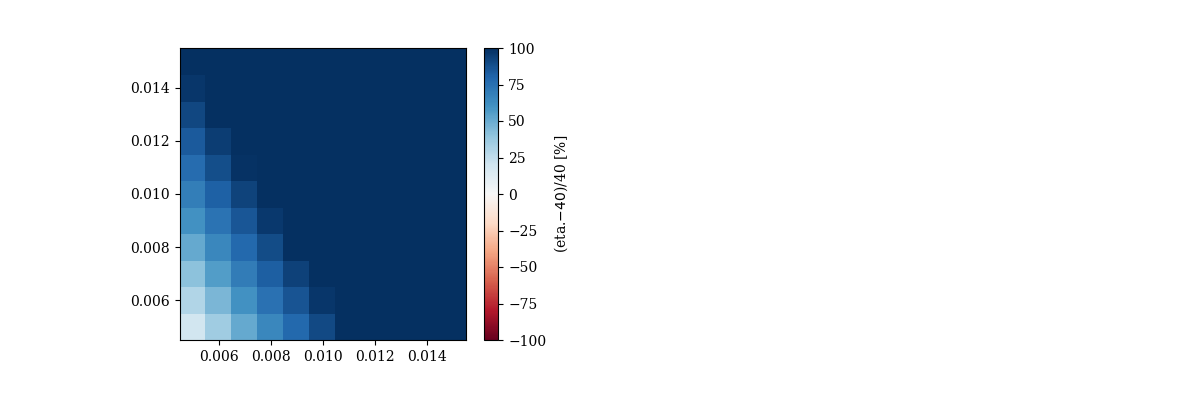

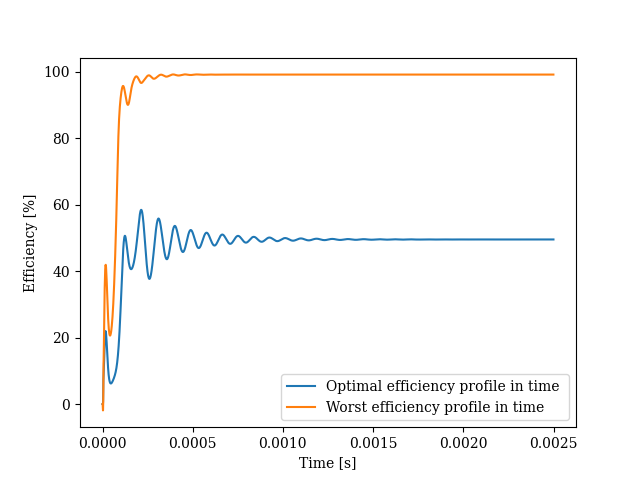

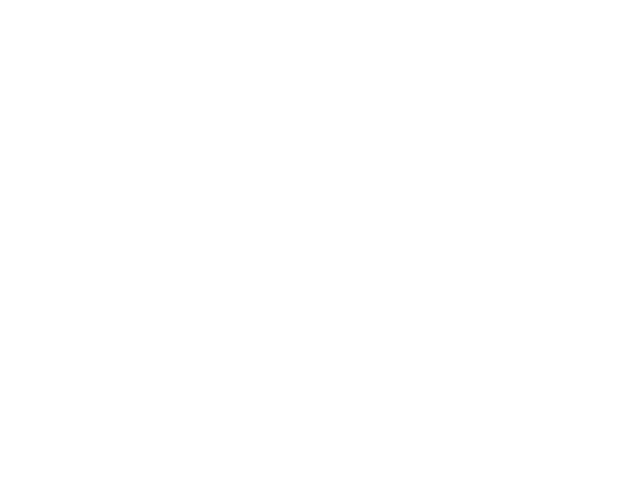

In [16]:
path = "Results_PPSX00/linear"
config = path +'/data_-1_-1/Configuration.cfg'
read_input_and_set_globals(config)


eta = np.zeros((2*lungh+1, 2*lungh+1))
alpha_B1 = []
alpha_B2 = []


for indx in range(-lungh,lungh+1):
    alpha_B1.append(indx/1000+0.01)
    for indy in range(-lungh,lungh+1):
        ng_tot = []
        ng_av_out = 0
        ng_av_in = 0
        ng_temp_in = []
        ng_temp_out = []
        t_tot = 0
        time_save = []
        Results = path + "/data_"+str(indx)+"_"+str(indy)
        ResultsFigs = Results+"/Figs"
        ResultsData = Results+"/Data"
        if not os.path.exists(ResultsFigs):
            os.makedirs(ResultsFigs)
        files       = glob.glob(ResultsData + "/*.pkl")
        for i_save, file in enumerate(files):
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                ng_tot.append(P[0,:])
                time_save.append(t)
        for i in range (len(ng_tot)) :
            ng_temp_out.append(np.mean(ng_tot[i][-10:-3]))
            ng_temp_in.append(np.mean(ng_tot[i][3:10]))
        time_scale = np.linspace(0, time_save[-1], len(time_save)*2+1)
        ng_av_out = np.mean(np.interp(time_scale, time_save, ng_temp_out))
        ng_av_in = np.mean(np.interp(time_scale, time_save, ng_temp_in))
        eta[indx+lungh][indy+lungh] = (1-(ng_av_out)/(ng_av_in))*100
        
        

eta_scaled = (eta - 40)*100/40
alpha_B2 = alpha_B1


plt.figure(figsize=(12, 4))  # Set figure size
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
ax0 = plt.subplot(gs1[0])
assi = [ax0, ax1]


vmin=0
if int(np.amin(eta_scaled)+1)>10:
    vmin = int(np.amin(eta_scaled))
vmax=int(np.amax(np.abs(eta_scaled))+1)
vmax = 100
vmin = -vmax

print(np.shape(eta_scaled),np.shape(alpha_B1),np.shape(alpha_B2))
im = ax0.pcolor(alpha_B1, alpha_B2, eta_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = r"(eta.$- 40$)/40 [%]")

# Extremal cases
ind_x_opti = 0 # We look for the set of alphaB with the lowest error
indy_opti = 0
eta_opti = 5000
indx_worst = 0 # We look for the set of alphaB with the highest error
indy_worst = 0
eta_worst = 0
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
        if abs(eta[lungh+indx, lungh+indy]-40) < eta_opti :
            indx_opti = indx
            indy_opti = indy
            eta_opti = abs(eta[lungh+indx, lungh+indy]-40)
        elif abs(eta[lungh+indx, lungh+indy]-40) > eta_worst :
            indx_worst = indx
            indy_worst = indy
            eta_worst = abs(eta[lungh+indx, lungh+indy]-40)
print(alpha_B1[lungh+indx_opti], alpha_B2[lungh+indy_opti],eta[lungh+indx_opti, lungh+indy_opti], (eta[lungh+indx_opti, lungh+indy_opti]-40)*100/40)
print(alpha_B1[lungh+indx_worst], alpha_B2[lungh+indy_worst],eta[lungh+indx_worst, lungh+indy_worst], (eta[lungh+indx_worst, lungh+indy_worst]-40)*100/40)
plt.show()

# Time variations

plt.figure()

eta_profile_opti = []
ng_tot = []
time_save = []
Results = path + "/data_"+str(indx_opti)+"_"+str(indy_opti)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ng_tot.append(P[0,:])
for i in range(len(ng_tot)) :
    eta_profile_opti.append(100*(1-(np.mean(ng_tot[i][-10:-3])/np.mean(ng_tot[i][3:10]))))

plt.plot(time_save, eta_profile_opti ,label = 'Optimal efficiency profile in time ')

eta_profile_worst = []
ng_tot = []
time_save = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        time_save.append(t)
        ng_tot.append(P[0,:])
for i in range(len(ng_tot)) :
    eta_profile_worst.append(100*(1-(np.mean(ng_tot[i][-10:-3])/np.mean(ng_tot[i][3:10]))))
    pass

plt.plot(time_save, eta_profile_worst ,label = 'Worst efficiency profile in time')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Efficiency [%]')




Text(0, 0.5, 'v_i [m/s]')

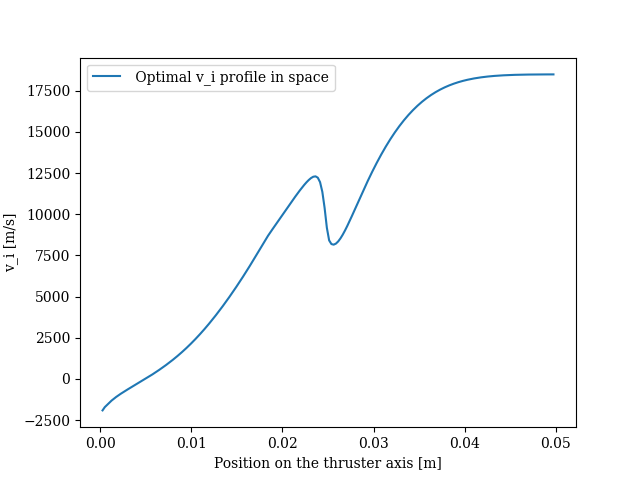

In [24]:
path = "Results_PPSX00/linear"
indx_plot = -4
indy_plot = -3
vi_profile = []
vi_tot = []
Results = path + "/data_"+str(indx_worst)+"_"+str(indy_worst)
ResultsFigs = Results+"/Figs"
ResultsData = Results+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
files       = glob.glob(ResultsData + "/*.pkl")
for i_save, file in enumerate(files):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        vi_tot.append(P[2,:])
for i in range(len(vi_tot[0])) :
    vi_profile.append(np.mean(vi_tot[-100][i]))
plt.figure()
plt.plot(x_center, vi_profile ,label = ' Optimal v_i profile in space')
plt.legend()
plt.xlabel('Position on the thruster axis [m]')
plt.ylabel('v_i [m/s]')

Results_PPSX00/linear/data_-5_-5
final time:  0.0024996557641101
Results_PPSX00/linear/data_-5_-4
final time:  0.0024992211687291403
Results_PPSX00/linear/data_-5_-3
final time:  0.0024991458110446237
Results_PPSX00/linear/data_-5_-2
final time:  0.0024997073660942616
Results_PPSX00/linear/data_-5_-1
final time:  0.00249982600430472
Results_PPSX00/linear/data_-5_0
final time:  0.002499596960386817
Results_PPSX00/linear/data_-5_1
final time:  0.00249973656592073
Results_PPSX00/linear/data_-5_2
final time:  0.0024992947102934534
Results_PPSX00/linear/data_-5_3
final time:  0.002499179345807393
Results_PPSX00/linear/data_-5_4
final time:  0.0024999044467170564
Results_PPSX00/linear/data_-5_5
final time:  0.0024999132940038745
Results_PPSX00/linear/data_-4_-5
final time:  0.0024993904202139676
Results_PPSX00/linear/data_-4_-4
final time:  0.0024997479885973278
Results_PPSX00/linear/data_-4_-3
final time:  0.0024994832532341327
Results_PPSX00/linear/data_-4_-2
final time:  0.002499694822990

KeyboardInterrupt: 

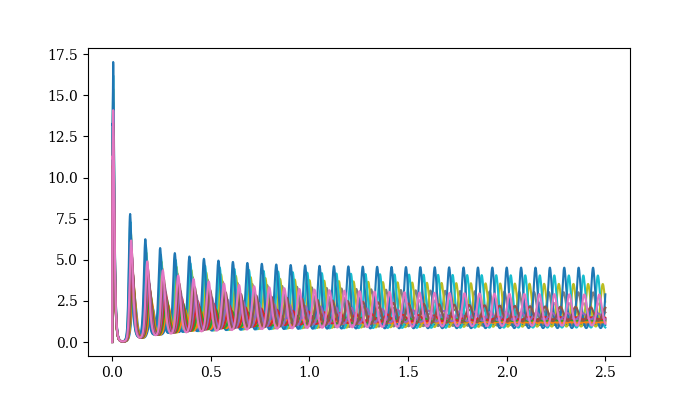

In [13]:
plt.figure(figsize=(7, 4))

for indx in range(-lungh,lungh+1):
    for indy in range(-lungh,lungh+1):
    # for indy in range(1, lungh+1):
        Results = path + "/data_" + str(indx) + "_" + str(indy)
        print(Results)
        calc_current(Results)
        ResultConfig = Results+'/Configuration.cfg'
        read_input_and_set_globals(ResultConfig)
    
        time,Current,Voltage = np.loadtxt(Results + "/cur_volt.dat")
    
        plt.plot(time*1e3, Current, label = fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
plt.xlabel("Time [ms]")
plt.ylabel("Current [A]")
plt.grid(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0,10)
plt.xlim(0,2)
plt.tight_layout()
plt.show()

# plt.savefig("images_compare_Kel/currents.png", dpi=300, transparent=True)


## Ion current profiles

In [ ]:
for indx in range(-lungh,lungh+1):
    for indy in range(-lungh, lungh+1):
        fig = plt.figure(figsize=(10, 10))
        gls = fig.add_gridspec(4, 1, hspace=0.1)
        gls.update(left=0.15, right=0.65, wspace=0.05)
        ax0 = fig.add_subplot(gls[0])
        ax1 = fig.add_subplot(gls[1])
        ax2 = fig.add_subplot(gls[2])
        ax2t = ax2.twinx()
        ax3 = fig.add_subplot(gls[3])

        Results = path + "data_" + str(indx) + "_" + str(indy)
        calc_current(Results)
        ResultsData = Results + "/Data"
        files = get_files(ResultsData)
        read_input_and_set_globals(Results + "/Configuration.cfg")
    
   # i_save = -1
        ng = np.zeros(NBPOINTS)
        ni = np.zeros(NBPOINTS)
        vi = np.zeros(NBPOINTS)
        Te = np.zeros(NBPOINTS)
        ve = np.zeros(NBPOINTS)
    
        for i_save, file in enumerate(files[-10:]):
            with open(file, 'rb') as f:
                [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
                ng += P[0,:]
                ni += P[1,:]
                vi += P[2,:]
                Te += P[3,:]
                ve += P[4,:]
        ng /= (i_save+1)
        ni /= (i_save+1)
        vi /= (i_save+1)
        Te /= (i_save+1)
        ve /= (i_save+1)
    
        ax0.plot(x_center*100, ng, label = "$n_g$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
        ax0.plot(x_center*100, ni, label = "$n_i$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
        ax1.plot(x_center*100, Te, label = "$T_e$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
        ax2.plot(x_center*100, vi, label = "$v_i$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
        ax2t.plot(x_center*100, ve, label = "$v_e$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
        ax3.plot(x_center*100, phy_const.elementary_charge*ve*ni, label = "e, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = ':')
        ax3.plot(x_center*100, phy_const.elementary_charge*vi*ni, label = "i, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
        ax3.plot(x_center*100, phy_const.elementary_charge*(vi-ve)*ni, label = "tot, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '-')
            
        ax0.set_ylabel(r'Density [m$^{-3}$]', fontsize=18)
        ax1.set_ylabel(r'Temperature [eV]', fontsize=18)
        ax2.set_ylabel(r'$v_i$ (dashed) [m/s]', fontsize=18)
        ax2t.set_ylabel(r'$v_e$ [m/s]', fontsize=18)
        ax3.set_xlabel(r'$x$ [cm]', fontsize=18)
        ax3.set_ylabel(r'$J$ [A/m$^2$]', fontsize=18)
        
        
        ax0.set_xlim(0, 5)
        ax1.set_xlim(0, 5)
        ax2.set_xlim(0, 5)
        ax3.set_xlim(0, 5)
        ax0.grid(False)
        ax1.grid(False)
        ax2.grid(False)
        ax2t.grid(False)
        ax3.grid(False)
        ax0.set_xticklabels([])
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])
        
        # ax0.set_ylim(1e16, 1e20)
        ax1.set_ylim(0, 15)
        ax2.set_ylim(-5e3, 15e3)
        ax2t.set_ylim(-1e5, 0)
        
        # ax3.legend()
        
        ax0.set_yscale('log')
        
        ax0.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
        ax1.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
        ax3.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
        
        
        fig.align_ylabels()
        
        plt.savefig(path + f"figures/current_profiles_"+str(indx)+"_"+str(indy)+".png", dpi=300, transparent=True, bbox_inches='tight')
        plt.close()


In [ ]:
path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi/data_cp_8/"
# path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_neg/data_cp_8/"
# path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_variable/data_cp_4/"
# path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_variable2/data_cp_4/"
# path = "/home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_variable3/data_cp_4/"


print(path)
ResultConfig = path +'Configuration.cfg'
configFile = ResultConfig
config = configparser.ConfigParser()
config.read(configFile)
physicalParameters = config['Physical Parameters']

fig = plt.figure(figsize=(10, 10))
gls = fig.add_gridspec(4, 1, hspace=0.1)
gls.update(left=0.15, right=0.65, wspace=0.05)
ax0 = fig.add_subplot(gls[0])
ax1 = fig.add_subplot(gls[1])
ax2 = fig.add_subplot(gls[2])
ax2t = ax2.twinx()
ax3 = fig.add_subplot(gls[3])

Results = path
# calc_current(Results)
ResultsData = path + "Data/"
files = get_files(ResultsData)
print(ResultsData, len(files))
read_input_and_set_globals(Results + "/Configuration.cfg")

# i_save = -1
ng = np.zeros(NBPOINTS)
ni = np.zeros(NBPOINTS)
vi = np.zeros(NBPOINTS)
Te = np.zeros(NBPOINTS)
ve = np.zeros(NBPOINTS)

for i_save, file in enumerate(files[-10:]):
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)
        ng += P[0,:]
        ni += P[1,:]
        vi += P[2,:]
        Te += P[3,:]
        ve += P[4,:]
ng /= (i_save+1)
ni /= (i_save+1)
vi /= (i_save+1)
Te /= (i_save+1)
ve /= (i_save+1)

ax0.plot(x_center*100, ng, label = "$n_g$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
ax0.plot(x_center*100, ni, label = "$n_i$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
ax1.plot(x_center*100, Te, label = "$T_e$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
ax2.plot(x_center*100, vi, label = "$v_i$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
ax2t.plot(x_center*100, ve, label = "$v_e$,~" + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}")
ax3.plot(x_center*100, -phy_const.elementary_charge*ve*ni, label = "e, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = ':')
ax3.plot(x_center*100, phy_const.elementary_charge*vi*ni, label = "i, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '--')
ax3.plot(x_center*100, phy_const.elementary_charge*(vi-ve)*ni, label = "tot, " + fr"$\alpha_c = ${alpha_B1:.4f}, $\alpha_p = ${alpha_B2:.4f}", ls = '-')
    
ax0.set_ylabel(r'Density [m$^{-3}$]', fontsize=18)
ax1.set_ylabel(r'Temperature [eV]', fontsize=18)
ax2.set_ylabel(r'$v_i$ (dashed) [m/s]', fontsize=18)
ax2t.set_ylabel(r'$v_e$ [m/s]', fontsize=18)
ax3.set_xlabel(r'$x$ [cm]', fontsize=18)
ax3.set_ylabel(r'$J$ [A/m$^2$]', fontsize=18)


ax0.set_xlim(0, 5)
ax1.set_xlim(0, 5)
ax2.set_xlim(0, 5)
ax3.set_xlim(0, 5)
ax0.grid(False)
ax1.grid(False)
ax2.grid(False)
ax2t.grid(False)
ax3.grid(False)
ax0.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# ax0.set_ylim(1e16, 1e20)
ax1.set_ylim(0, 15)
ax2.set_ylim(-5e3, 15e3)
ax2t.set_ylim(-1e5, 0)

# ax3.legend()

ax0.set_yscale('log')

ax0.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
ax1.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)
ax3.legend(bbox_to_anchor=(1.001, 1), loc='upper left', frameon=False, fontsize=11)


fig.align_ylabels()

# plt.savefig(path + f"figures/current_profiles_{indx}_{indy}.png", dpi=300, transparent=True, bbox_inches='tight')
# plt.close()

In [ ]:
%matplotlib widget
indx = 10
indy = 7
path = "home/petronio/LPP1D/SPT100_gradP/change_Kel_psi_variable3/data_cp_4/"
time_scale, Id_interp, Va_interp = calc_curr(path)

plt.figure()
plt.plot(time_scale*1e3, Id_interp, label="interpolated current", color="darkred", marker = "d", linestyle="")

In [ ]:
## 2D map
lenx = 8
leny = 8
result_matrix = np.zeros((lenx, leny, 6))
for indx in range(1,lenx+1):
    for indy in range(1,leny+1):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'        
        result_matrix[indx-1, indy-1, :] = np.loadtxt(folder + "data_curr_BM_freq.txt", skiprows = 1)
#        print(indx,indy,result_matrix[indx-1, indy-1, 0])

In [ ]:
def make_figure(results, title, xlabel, ylabel, vec, colobarlab):
    vmin=0
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=int(np.amax(results)+1)
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vec, vec, results, cmap='magma', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap

def make_figure_diff(results, title, xlabel, ylabel, vec, colobarlab):
    
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=int(np.amax(results)+1)
    vmin=-vmax
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vec, vec, results, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap



In [ ]:
path_res = path + "data_cp_1_1/"
print(path_res)

ResultConfig = path_res +'Configuration.cfg'
configFile = ResultConfig
config = configparser.ConfigParser()
config.read(configFile)
physicalParameters = config['Physical Parameters']

In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start/np.arange(1,9)
results = result_matrix[:, :, 0]
colobarlab = "mean current [A]"

make_figure(results, title, xlabel, ylabel, vec, colobarlab)
plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
vec =  0.0250/np.arange(1,9)
results = result_matrix[:, :, 1]
colobarlab = "mean voltage [V]"

make_figure(results,  title, xlabel, ylabel, vec, colobarlab)

plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_volt_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
vec =  0.0250/np.arange(1,9)
results = result_matrix[:, :, 3]
colobarlab = "std curr [A]"

make_figure(results,  title, xlabel, ylabel, vec, colobarlab)

plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/std_curr_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start/np.arange(1,9)
results = result_matrix[:, :, 0] - 2.03
colobarlab = "mean current [A]"

make_figure_diff(results, title, xlabel, ylabel, vec, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
%matplotlib widget
plt.figure(figsize=(12.,9))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(hspace=0.2, wspace=0.15, left=0.15, right=0.65, bottom=0.1)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])

for ind_a in range(len(results[:,0])):
    ax0.plot(alpha_B1, mean_curr_scaled[:,ind_a], marker="v", label = rf"$\alpha $ plume $ = $ {alpha_B2[ind_a]:.3e}")
    ax1.plot(alpha_B2, mean_curr_scaled[ind_a,:], marker="d", label = rf"$\alpha $ channel $ = $ {alpha_B1[ind_a]:.3e}")
    # ax0.axvline(vec[ind_a], linestyle = "--")
    # ax1.axvline(vec[ind_a], linestyle = "--")
ax0.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax1.legend(bbox_to_anchor=(1, 1), loc="upper left")

ax0.axhline(y=0, alpha=.5, linewidth=5, color='darkred')
ax1.axhline(y=0, alpha=.5, linewidth=5, color='darkred')

ax0.set_xlabel(r'$\alpha$ channel', fontsize=18)
ax1.set_xlabel(r'$\alpha$ plume', fontsize=18)

ax0.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)
ax1.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)

# for bla in range(4):
#     if bla == 0:
#         CP4 = True
#     if bla == 1:
#         CP4 = False
#         CP5 = True
#     if bla == 2:
#         CP5 = False
#         CP6 = True
#     if bla == 3:
#         CP6 = False
#         CP7 = True
#     if CP4:
#         min_ch = 0.0089
#         # min_ch = 0.0074 + 0.0007625 * 1 - 0.0007625
#         max_ch = 0.0125
#         # max_ch = 0.0074 + 0.0007625 * 8 - 0.0007625
#         min_pl = 0.0051
#         # min_pl = 0.0045 + 0.0002187 * 1 - 0.0002187
#         max_pl = 0.00625
#         # max_pl = 0.0045 + 0.0002187 * 8 - 0.0002187
#         ax0.text(min_pl, 3, "CP4", fontsize=13, color=colors[bla])
#     elif CP5:
#         min_ch = 0.0046
#         max_ch = 0.0083
#         min_pl = 0.0068
#         max_pl = 0.0090
#         print("CP5")
#         ax0.text(min_pl, 2, "CP5", fontsize=13, color=colors[bla])
#     elif CP6:
#         min_ch = 0.0034
#         max_ch = 0.0043
#         min_pl = 0.0134
#         max_pl = 0.0440
#         print("CP6")
#         ax0.text(min_pl, 3, "CP6", fontsize=13, color=colors[bla])
#     elif CP7:
#         # min_ch = 0.0089
#         min_ch = 0.0074 + 0.0007625 * 1 - 0.0007625
#         # max_ch = 0.0125
#         max_ch = 0.0074 + 0.0007625 * 8 - 0.0007625
#         # min_pl = 0.0051
#         min_pl = 0.0045 + 0.0002187 * 1 - 0.0002187
#         max_pl = 0.00625
#         max_pl = 0.0045 + 0.0002187 * 8 - 0.0002187
#         print("CP4", min_ch, max_ch, min_pl, max_pl)
#         print((max_pl - min_pl)/8)
#         ax0.text(min_pl, 2, "CP7", fontsize=13, color=colors[bla])
#     ax0.axvspan(xmin=min_pl, xmax=max_pl, alpha=.5, color = colors[bla])
#     ax1.axvspan(xmin=min_ch, xmax=max_ch, alpha=.5, color = colors[bla])

# ax0.set_xscale('log')
# ax1.set_xscale('log')

# ax0.set_xticks(vec)
# ax1.set_xticks(vec)

# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/change_alpha_var.png",dpi=300, transparent=True, bbox_inches='tight')


## Graphs micro

In [ ]:
def make_figure_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab):
    vmin=0
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=np.amax(results)
    vmin=(2*np.mean(results) - vmax)
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vecx, vecy, results, cmap='magma', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap

def make_figure_diff_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab):
    
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=np.amax(results)
    vmin=-vmax
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vecx, vecy, results, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap



In [ ]:
# path = "test_multiple_alpha_B_SPT100/alpha_CP/"
path = "test_multiple_alpha_B_SPT100/alpha_CP4/"
# path = "test_multiple_alpha_B_SPT100/alpha_CP5/"
path = "test_multiple_alpha_B_SPT100/alpha_CP6/"
# path = "test_multiple_alpha_B_SPT100/alpha_CP7/"
path = "test_multiple_alpha_B_SPT100/alpha_CP8/"

for indx in range(1,9):
    for indy in range(1,9):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'
        mean_current, mean_volta = make_fig_curr_FFT(path + 'figures/', folder, indx, indy, False)
    #    print(mean_current, mean_volta)
        plt.close()

In [ ]:
## 2D map
lenx = 8
leny = 8
result_matrix = np.zeros((lenx, leny, 4))
for indx in range(1,lenx+1):
    for indy in range(1,leny+1):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'        
        result_matrix[indx-1, indy-1, :] = np.loadtxt(folder + "data_curr_BM_freq.txt", skiprows = 1)
#        print(indx,indy,result_matrix[indx-1, indy-1, 0])

In [ ]:
try:
    vecx = np.loadtxt(path + 'vec_x.txt') 
    vecy = np.loadtxt(path + 'vec_y.txt')
    print("vecx and vecy loaded from: ", path)

    physicalParameters = config['Physical Parameters']
    vecx[indx-1] = float(physicalParameters['Anomalous transport alpha_B1'])
    physicalParameters = config['Physical Parameters']
    vecy[indy-1] = float(physicalParameters['Anomalous transport alpha_B2'])

except:
    vecx = np.zeros(8)
    vecy = np.zeros(8)
    for indx in range(1,9):
        path_res = path + f"data_cp_{indx}_1/"
        print(path_res)
        
        ResultConfig = path_res +'Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
        vecx[indx-1] = float(physicalParameters['Anomalous transport alpha_B1'])
        
    for indy in range(1,9):
        path_res = path + f"data_cp_1_{indy}/"
        print(path_res)
        
        ResultConfig = path_res +'Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
        vecy[indy-1] = float(physicalParameters['Anomalous transport alpha_B2'])
    np.savetxt(path + 'vec_x.txt', vecx)
    np.savetxt(path + 'vec_y.txt', vecy)
print(vecx)
print(vecy)




In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ plume'
ylabel = r'$\alpha$ channel'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
results = result_matrix[:, :, 0]
colobarlab = "mean current [A]"

make_figure_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')

print(result_matrix[0, 0, 0])
print(result_matrix[-1, 0, 0])
print(result_matrix[0, -1, 0])
print(result_matrix[-1, -1, 0])


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ plume'
ylabel = r'$\alpha$ channel'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start + np.arange(1,9)
results = result_matrix[:, :, 0] - 2.03
colobarlab = "mean current [A]"

make_figure_diff_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
%matplotlib widget
plt.figure(figsize=(12.,9))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(hspace=0.2, wspace=0.15, left=0.15, right=0.65, bottom=0.1)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])

for ind_a in range(len(results[:,0])):
    ax0.plot(vecx, results[:,ind_a], marker="v", label = rf"$\alpha $ plume $ = $ {vecy[ind_a]:.3e}")
    ax1.plot(vecy, results[ind_a,:], marker="d", label = rf"$\alpha $ channel $ = $ {vecx[ind_a]:.3e}")
ax0.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax1.legend(bbox_to_anchor=(1, 1), loc="upper left")

ax0.axhline(y=0, alpha=.5, linewidth=5, color='darkred')
ax1.axhline(y=0, alpha=.5, linewidth=5, color='darkred')

ax0.set_xlabel(r'$\alpha$ channel', fontsize=18)
ax1.set_xlabel(r'$\alpha$ plume', fontsize=18)

ax0.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)
ax1.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)

# ax0.set_xscale('log')
# ax1.set_xscale('log')

# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/change_alpha_var.png",dpi=300, transparent=True, bbox_inches='tight')
